# Check Gpu

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


# Imports

In [17]:
!pip install lenstronomy
!pip install corner
!pip install image-similarity-measures
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import copy
from random import *
import pandas as pd
import os.path
from PIL import Image
import matplotlib.image
import zipfile
import sys
import warnings
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# rgb 2 gray 
from skimage.color import rgb2gray

#import the lens_plot module
from lenstronomy.Plots import lens_plot
from lenstronomy.Plots.model_plot import ModelPlot

## import Lens Model used named EPL
from lenstronomy.LensModel.Profiles import epl

# import main simulation class of lenstronomy
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.ImSim.image_model import ImageModel


# lenstronomy utility functions
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
# import the ShapeletSet class
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar


# Deep Learning packages
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image

# Loss packages
from skimage import measure

import cv2
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr

import phasepack.phasecong as pc

# Functions to generate Datasets

## Lens and Source model used to generate images

In [19]:
## Function that define Lens model parameters

def lens_model__(theta_E,gamma,e1,e2):
  kwargs_epl = {'theta_E': theta_E, 'gamma': gamma, 'center_x': 0, 'center_y': 0, 'e1': e1, 'e2': e2} 
  return kwargs_epl

## Function that define Source models parameters

def source_model__(source_type,amp,e1,e2,center_x,center_y):

  if source_type == 'SERSIC_ELLIPSE':
    kwargs_sersic = {'amp': amp, 'R_sersic': 0.1, 'n_sersic': 1.5, 'e1':e1,'e2':e2,'center_x': center_x, 'center_y': center_y}
    return kwargs_sersic 

  if source_type == 'HERNQUIST':
    kwargs_Hernquist={ 'amp': amp,'Rs':0.71,'center_x': center_x, 'center_y': center_y}
    return kwargs_Hernquist
  
  if source_type=='POWER_LAW':
    kwargs_power_law={'amp': 0.5*amp, 'gamma':0.01, 'e1':0.1*e1,'e2':0.1*e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_power_law

  if source_type=='ELLIPSOID':
    kwargs_ellipsoid={'amp': amp, 'radius':0.1, 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_ellipsoid

  if source_type=='UNIFORM':
    kwargs_UNIFORM={'amp': amp}
    return kwargs_UNIFORM

  if source_type=='GAUSSIAN_ELLIPSE':
    kwargs_gaussian_ellipse={'amp': amp, 'sigma':0.11, 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_gaussian_ellipse

  if source_type=='CHAMELEON':
    w_c=0.1
    w_t=1
    kwargs_chameleon={'amp':amp, 'w_c':w_c, 'w_t':w_t, 'e1':e1, 'e2':e2, 'center_x':center_x, 'center_y': center_y}
    return kwargs_chameleon
    
  if source_type=='MULTI_GAUSSIAN_ELLIPSE':
    kwargs_gaussian_multi_ellipse={'amp': [amp,0.1*amp,0.5*amp], 'sigma':[0.11,0.3,0.8], 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_gaussian_multi_ellipse
  
  if source_type=='NIE':
    s_scale=1
    kwargs_NIE={'amp': amp, 'e1':e1,'e2':e2, 's_scale':0.5, 'center_x': center_x, 'center_y': center_y}
    return kwargs_NIE
  
  if source_type=='PJAFFE_ELLIPSE':
    Ra=1
    Rs=5
    kwargs_jaffe={'amp': amp,'Ra':Ra, 'Rs':Rs, 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_jaffe

## Generation Dataset with Lenstronomy package Function

In [20]:
def generating_dataset(n,folder_path_dataset,data_class,psf_class,kwargs_numerics,exp_time,background_rms,x, y):
  
  variable_dataset=False      
  if not os.path.exists(folder_path_dataset):
      os.makedirs(folder_path_dataset)
      
      variable_dataset=True
  
  if variable_dataset:
      ## No light model for the lens
      lens_light_model_list = []
      kwargs_lens_light_list = []
      
      ## Initialization of dataset
      unlensed_dataset=[]
      lensed_dataset=[]
      noisy_dataset=[]
      
      lens_parameters_dataset=[]
      source_type_dataset=[]
      source_parameters_dataset=[]
      ## Type of sources used in the dataset
      source_type_list=['SERSIC_ELLIPSE','HERNQUIST','NIE','CHAMELEON']#,'POWER_LAW']#,'GAUSSIAN_ELLIPSE']#MULTI_GAUSSIAN_ELLIPSE'],'UNIFORM','ELLIPSOID']#,'POWER_LAW',,'UNIFORM','GAUSSIAN_ELLIPSE',,'ELLIPSOID',
      
      ## Type of Lens used in the dataset
      lens_type_list=['EPL']#['EPL','SHEAR','POINT_MASS','SIS','NIE','SIE','SERSIC']#',CORED_DENSITY',,'CURVED_ARC_SIS_MST']
      
      ## number of sources
      nb_source=len(source_type_list)
      
      ##
      Maxim_global=0
      
      for i in tqdm(range(n)):
        source_model_list=[]
        kwargs_source=[]
        
        ## Choice of number of sources
        choix_nb_source=np.random.randint(5,11)
        L_choix_source=np.random.randint(0,nb_source,choix_nb_source)
    
        ## Parameters of each sources
        for k in L_choix_source:
          source_type=source_type_list[k]
          amp_s=uniform(200,600)
          e1_s=uniform(-0.3,0.3)
          e2_s=uniform(-0.3,0.3) 
          center_x=uniform(-2.5,2.5)
          center_y=uniform(-2.5,2.5)
    
          source_model_list.append(source_type)
          kwargs_source_type=source_model__(source_type,amp_s,e1_s,e2_s,center_x,center_y)
          kwargs_source.append(kwargs_source_type)
    
        source_model_class = LightModel(source_model_list)
        kwargs_label_source=[source_model_list,kwargs_source]    
        
        ## Lens_parameters
        gamma=uniform(-0.5,0.5)
        e1=uniform(-0.3,0.3)
        e2=uniform(-0.3,0.3)
        theta_E=uniform(0.3,0.8)
           
        lens_type='EPL'   
        lens_model_list = [lens_type]
        lens_model_class = LensModel(lens_model_list)
    
        kwargs_lens_type=lens_model__(theta_E,gamma,e1,e2)
        kwargs_lens=[kwargs_lens_type]
    
        kwargs_label_lens=[lens_model_list,kwargs_lens]
        
        
        ### Generation DATA
        
        # image without noise
        imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, source_model_class=source_model_class, kwargs_numerics=kwargs_numerics)#, lens_light_model_class=None,point_source_class=None)
        image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None, source_add=True,lens_light_add=False,  point_source_add=False)
        
        lensed_dataset.append(np.array(image_model))
        
        # noisy image
        poisson = image_util.add_poisson(image_model, exp_time=exp_time)
        bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
        image_real = image_model + poisson + bkg
        
        noisy_dataset.append(np.array(image_real))
        
        # unlensed image
        imageModel_u = ImageModel(data_class, psf_class, kwargs_numerics=kwargs_numerics,source_model_class=source_model_class)#,lens_model_class=None)#, lens_light_model_class=None,point_source_class=None)
        unlensed_image = imageModel_u.image(kwargs_lens=None, kwargs_source=kwargs_source, kwargs_lens_light=None, kwargs_ps=None, source_add=True, lens_light_add=False,point_source_add=False)
        
        unlensed_dataset.append(np.array(unlensed_image))
        
        # Maximum update
        maxim_local=np.max((unlensed_image,image_model))
        Maxim_global=np.max((maxim_local,Maxim_global))


        lens_parameters_dataset.append(np.array([theta_E,gamma,0,0,e1,e2]))
        source_type_dataset.append(source_model_list)
        source_parameters_dataset.append(kwargs_source)
      
      
      unlensed_dataset=np.array(unlensed_dataset)
      lensed_dataset=np.array(lensed_dataset)
      noisy_dataset=np.array(noisy_dataset)
      
      
      lens_parameters_dataset=np.array(lens_parameters_dataset)
      source_type_dataset=np.array(source_type_dataset)
      source_parameters_dataset=np.array(source_parameters_dataset)
      
      ## Same scale to have Relative brightness between images for the training
      noisy_dataset=noisy_dataset/Maxim_global
      lensed_dataset=lensed_dataset/Maxim_global
      unlensed_dataset=unlensed_dataset/Maxim_global
      
      ## Save
      np.save(folder_path_dataset+'/unlensed_dataset'+'.npy', unlensed_dataset)
      np.save(folder_path_dataset+'/lensed_dataset'+'.npy', lensed_dataset)
      np.save(folder_path_dataset+'/noisy_dataset'+'.npy', noisy_dataset)
      
      
      np.save(folder_path_dataset+'/lens_parameters.npy',lens_parameters_dataset)
      np.save(folder_path_dataset+'/source_types.npy',source_type_dataset)
      np.save(folder_path_dataset+'/source_parameters.npy',source_parameters_dataset) 


## Shapelet Reconstruction Function

In [21]:
def shapelet_reconstruction(n,folder_path_dataset,folder_path_reconstruction,choice_type_shapelet,beta,nmax,x,y,deltaPix):
  variable_dataset=False
    
  if not os.path.exists(folder_path_reconstruction):
    os.makedirs(folder_path_reconstruction)
    
    ## Image Dataset
    
    filename='unlensed_dataset.npy'
    unlensed_dataset=np.load(folder_path_dataset+'/'+filename)
    
    filename='lensed_dataset.npy'
    lensed_dataset=np.load(folder_path_dataset+'/'+filename)
    
    filename='noisy_dataset.npy'
    noisy_dataset=np.load(folder_path_dataset+'/'+filename)

    variable_dataset=True
    
  if variable_dataset:
      
      unlensed_dataset_reconstructed=[]
      lensed_dataset_reconstructed=[]
      noisy_dataset_reconstructed=[]
      
      unlensed_coeff_dataset=[]
      lensed_coeff_dataset=[]
      noisy_coeff_dataset=[]
     
      ## Choose the type of shapelets : Polar or Cartesian shapelets
      shapeletSet = choice_type_shapelet
      
       
      for i in tqdm(range(n)):
        
        data=unlensed_dataset[i]
        image_1d = util.image2array(data)
        coeff_ngc = shapeletSet.decomposition(image_1d, x, y, nmax, beta, deltaPix=deltaPix, center_x=0, center_y=0) 
        # reconstruct the image with the shapelet coefficients
        image_reconstructed = shapeletSet.function(x, y, coeff_ngc, nmax, beta, center_x=0, center_y=0)
        # turn 1d array back into 2d image
        image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image
        #image_reconstructed_2d=image_reconstructed_2d/np.max(image_reconstructed_2d)
        # save in the wanted folder
        #matplotlib.image.imsave(source_reconstruction+'/Unlensed_Dataset/'+str(i)+'.png',image_reconstructed_2d,vmin=np.min(image_reconstructed_2d),vmax=np.max(image_reconstructed_2d))
        unlensed_dataset_reconstructed.append(np.array(image_reconstructed_2d))
        unlensed_coeff_dataset.append(np.array(coeff_ngc))
        
        
        data=lensed_dataset[i]
        image_1d = util.image2array(data)  
        # decompose image and return the shapelet coefficients
        coeff_ngc = shapeletSet.decomposition(image_1d, x, y, nmax, beta, deltaPix=deltaPix, center_x=0, center_y=0) 
        # reconstruct the image with the shapelet coefficients
        image_reconstructed = shapeletSet.function(x, y, coeff_ngc, nmax, beta, center_x=0, center_y=0)
        # turn 1d array back into 2d image
        image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image
        #image_reconstructed_2d=image_reconstructed_2d/np.max(image_reconstructed_2d)
        # save in the wanted folder
        #matplotlib.image.imsave(source_reconstruction+'/Lensed_Dataset/'+str(i)+'.png',image_reconstructed_2d,vmin=np.min(image_reconstructed_2d),vmax=np.max(image_reconstructed_2d))
        lensed_dataset_reconstructed.append(np.array(image_reconstructed_2d))
        lensed_coeff_dataset.append(np.array(coeff_ngc))
        
        '''
        data=noisy_dataset[i]
        image_1d = util.image2array(data)  
        # decompose image and return the shapelet coefficients
        coeff_ngc = shapeletSet.decomposition(image_1d, x, y, nmax, beta, deltaPix=deltaPix, center_x=0, center_y=0) 
        # reconstruct the image with the shapelet coefficients
        image_reconstructed = shapeletSet.function(x, y, coeff_ngc, nmax, beta, center_x=0, center_y=0)
        # turn 1d array back into 2d image
        image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image
        #image_reconstructed_2d=image_reconstructed_2d/np.max(image_reconstructed_2d)
        # save in the wanted folder
        #matplotlib.image.imsave(source_reconstruction+'/Noisy_Dataset/'+str(i)+'.png',image_reconstructed_2d,vmin=np.min(image_reconstructed_2d),vmax=np.max(image_reconstructed_2d))
        noisy_dataset_reconstructed.append(np.array(image_reconstructed_2d))
        noisy_coeff_dataset.append(np.array(coeff_ngc))
        '''
        
      unlensed_dataset_reconstructed=np.array(unlensed_dataset_reconstructed)
      unlensed_coeff_dataset=np.array(unlensed_coeff_dataset)
    
      lensed_dataset_reconstructed=np.array(lensed_dataset_reconstructed)
      lensed_coeff_dataset=np.array(lensed_coeff_dataset)

      '''
      noisy_dataset_reconstructed=np.array(noisy_dataset_reconstructed)
      noisy_coeff_dataset=np.array(noisy_coeff_dataset)
      '''

      print(len(coeff_ngc))
      ## Save
      np.save(folder_path_reconstruction+'/unlensed_dataset_reconstructed_images'+'.npy', unlensed_dataset_reconstructed)
      np.save(folder_path_reconstruction+'/lensed_dataset_reconstructed_images'+'.npy', lensed_dataset_reconstructed)
      #np.save(folder_path_reconstruction+'/noisy_dataset_reconstructed_images'+'.npy', noisy_dataset_reconstructed)
      
      
      np.save(folder_path_reconstruction+'/unlensed_dataset_reconstructed_coeff'+'.npy', unlensed_coeff_dataset)
      np.save(folder_path_reconstruction+'/lensed_dataset_reconstructed_coeff'+'.npy', lensed_coeff_dataset)
      #np.save(folder_path_reconstruction+'/noisy_dataset_reconstructed_coeff'+'.npy', noisy_coeff_dataset)

# Dataset

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Images Dataset Generated with Lenstronomy

In [23]:
folder_path_dataset='/content/drive/MyDrive/Dataset_PFE'
if not os.path.exists(folder_path_dataset):
    n=10000

    # data specifics
    background_rms = .005  #  background noise per pixel
    exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
    numPix =128  #  cutout pixel size
    deltaPix =0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
    fwhm = 0.05  # full width half max of PSF
    psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

    # generate the coordinate grid and image properties
    kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
    data_class = ImageData(**kwargs_data)

    # generate the psf variables
    kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    # The grid for images
    x, y = util.make_grid(numPix, deltaPix)

    generating_dataset(n,folder_path_dataset, data_class, psf_class, kwargs_numerics, exp_time, background_rms, x, y)


## Image Dataset
filename='unlensed_dataset.npy'
unlensed_dataset=np.load(folder_path_dataset+'/'+filename)

filename='lensed_dataset.npy'
lensed_dataset=np.load(folder_path_dataset+'/'+filename)

filename='noisy_dataset.npy'
noisy_dataset=np.load(folder_path_dataset+'/'+filename)

## Label Datasets
filename='lens_parameters.npy'
lens_parameters_dataset=np.load(folder_path_dataset+'/'+filename)

filename='source_types.npy'
source_type_dataset=np.load(folder_path_dataset+'/'+filename,allow_pickle=True)

filename='source_parameters.npy'
source_parameters_dataset=np.load(folder_path_dataset+'/'+filename,allow_pickle=True)


## Shapelet Image Reconstructed Dataset

In [24]:
folder_path_reconstruction='/content/drive/MyDrive/Shapelet_dataset'
if not os.path.exists(folder_path_reconstruction):
  #n_=n
  choice_type_shapelet=ShapeletSet()

  numPix=128
  deltaPix=0.05
  theta_min=deltaPix
  theta_max=numPix

  beta=0.325  #np.sqrt(theta_max*theta_min)
  nmax=80  #np.min((170,int(theta_max/theta_min-1)))

  print('\nbeta = '+str(beta))
  print('nmax = '+str(nmax))

  x,y=util.make_grid(numPix=theta_max,deltapix=theta_min)
  delta=deltaPix

  shapelet_reconstruction(n,folder_path_dataset,folder_path_reconstruction,choice_type_shapelet,beta,nmax,x,y,delta)


filename='lensed_dataset_reconstructed_images.npy'
lensed_dataset_reconstructed_images=np.load(folder_path_reconstruction+'/'+filename)

filename='lensed_dataset_reconstructed_coeff.npy'
lensed_dataset_reconstructed_coeff=np.load(folder_path_reconstruction+'/'+filename)

filename='unlensed_dataset_reconstructed_images.npy'
unlensed_dataset_reconstructed_images=np.load(folder_path_reconstruction+'/'+filename)#,allow_pickle=True)

filename='unlensed_dataset_reconstructed_coeff.npy'
unlensed_dataset_reconstructed_coeff=np.load(folder_path_reconstruction+'/'+filename)#,allow_pickle=True)


# Vizualize Dataset

## Functions

In [8]:
## For the Lens Model Plot we need the position of the sources, we have it in the labelset
def coord_source_pos(source_parameters_dataset,n):
  L_sourcePos_x=[]
  L_sourcePos_y=[]

  for ind in range(n):
    label_source=source_parameters_dataset[ind]
    sourcePos_x=[]
    sourcePos_y=[]
    for i in range(len(label_source)):
      center_x=label_source[i]["center_x"]
      center_y=label_source[i]["center_y"]
      sourcePos_x.append(center_x)
      sourcePos_y.append(center_y)
    L_sourcePos_x.append(sourcePos_x)
    L_sourcePos_y.append(sourcePos_y)

  return L_sourcePos_x,L_sourcePos_y


def vizualize_dataset(L_affichage,unlensed_dataset,lensed_dataset,noisy_dataset,lens_parameters_dataset,source_parameters_dataset,n,nb_affichage,numPix,deltaPix):
  numPix,deltaPix=numPix,deltaPix
  
  lens_type='EPL'   
  lens_model_list = [lens_type]
  lensModel=LensModel(lens_model_list)

  L_sourcePos_x,L_sourcePos_y=coord_source_pos(source_parameters_dataset,n)
  
  i=0
  nb_ligne=len(L_affichage)
  f, axes = plt.subplots(nb_ligne, 4, figsize=(2*nb_ligne, 6*nb_ligne), sharex=False, sharey=False)
  for ind in L_affichage:
    
    # sequence of weak lensing
    ax = axes[i][0]
    im = ax.matshow(unlensed_dataset[ind], origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Unlensed Image')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
      
    ax = axes[i][1]
    im = ax.matshow(lensed_dataset[ind], origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,  extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Lensed Image')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    

    ax = axes[i][2]
    im = ax.matshow(noisy_dataset[ind], origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,  extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Noisy image')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')

    
    sourcePos_x=L_sourcePos_x[ind]
    sourcePos_y=L_sourcePos_y[ind]
    label_lens=lens_parameters_dataset[ind]
    kwargs_lens=[{'theta_E': label_lens[0], 'gamma': label_lens[1], 'center_x': label_lens[2], 'center_y': label_lens[3], 'e1': label_lens[4], 'e2':label_lens[5] }]
    ax=axes[i][3]
    lens_plot.lens_model_plot(ax,lensModel,kwargs_lens,numPix,deltaPix,sourcePos_x,sourcePos_y,with_caustics=True,with_convergence=True)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Lens Model PEMD')
    
    i=i+1

  plt.show()


def vizualize_dataset_shapelet(L_affichage,unlensed_dataset_reconstructed,lensed_dataset_reconstructed,n,nb_affichage):
  
 
  nb_ligne=len(L_affichage)
  i=0
  f, axes = plt.subplots(nb_ligne, 2, figsize=(2*nb_ligne, 6*nb_ligne), sharex=False, sharey=False)
  for ind in L_affichage:
    # sequence of weak lensing
    ax = axes[i][0]
    im = ax.matshow(unlensed_dataset_reconstructed[ind], origin='lower')#, vmin=v_min, vmax=v_max, cmap=cmap,  extent=[0, 1, 0, 1]) #vmin=v_min, vmax=v_max, cmap=cmap,
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('Unlensed image')
    ax.autoscale(False)
    
    ax = axes[i][1]
    im = ax.matshow(lensed_dataset_reconstructed[ind], origin='lower')#, vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1]) #vmin=v_min, vmax=v_max, cmap=cmap,
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('Lensed image')
    ax.autoscale(False)

    '''
    ax = axes[i][2]
    im = ax.matshow(noisy_dataset_reconstructed[ind], origin='lower')#, vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1]) #vmin=v_min, vmax=v_max, cmap=cmap,
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('Noisy image')
    ax.autoscale(False)
    '''
    i=i+1

  plt.show()


def vizualize_dataset_coeff_shapelet(len_coeff_shapelet,unlensed_dataset_reconstructed_coeff,lensed_dataset_reconstructed_coeff,L_affichage,n,nb_affichage):
  
  x_ax_shapelett=np.linspace(0,len_coeff_shapelet-1,num=len_coeff_shapelet,dtype='int')

  nb_ligne=len(L_affichage)
  i=0
  f, axes = plt.subplots(nb_ligne, 2, figsize=(2*nb_ligne, 6*nb_ligne), sharex=False, sharey=False)
  for ind in L_affichage:
    # sequence of weak lensing
    ax = axes[i][0]
    ax.plot(x_ax_shapelett,unlensed_dataset_reconstructed_coeff[ind])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_title('Unlensed image')
    
    ax = axes[i][1]
    ax.plot(x_ax_shapelett,lensed_dataset_reconstructed_coeff[ind])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_title('Lensed image')
    
    '''
    ax = axes[i][2]
    ax.plot(x_ax_shapelett,noisy_dataset_reconstructed_coeff[ind])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_title('Noisy image')
    '''
    i=i+1

  plt.show()
  


## Generated Dataset

indices of data plotted = [   0 1111 2222 3333 4444 5555 6666 7777 8888 9999]


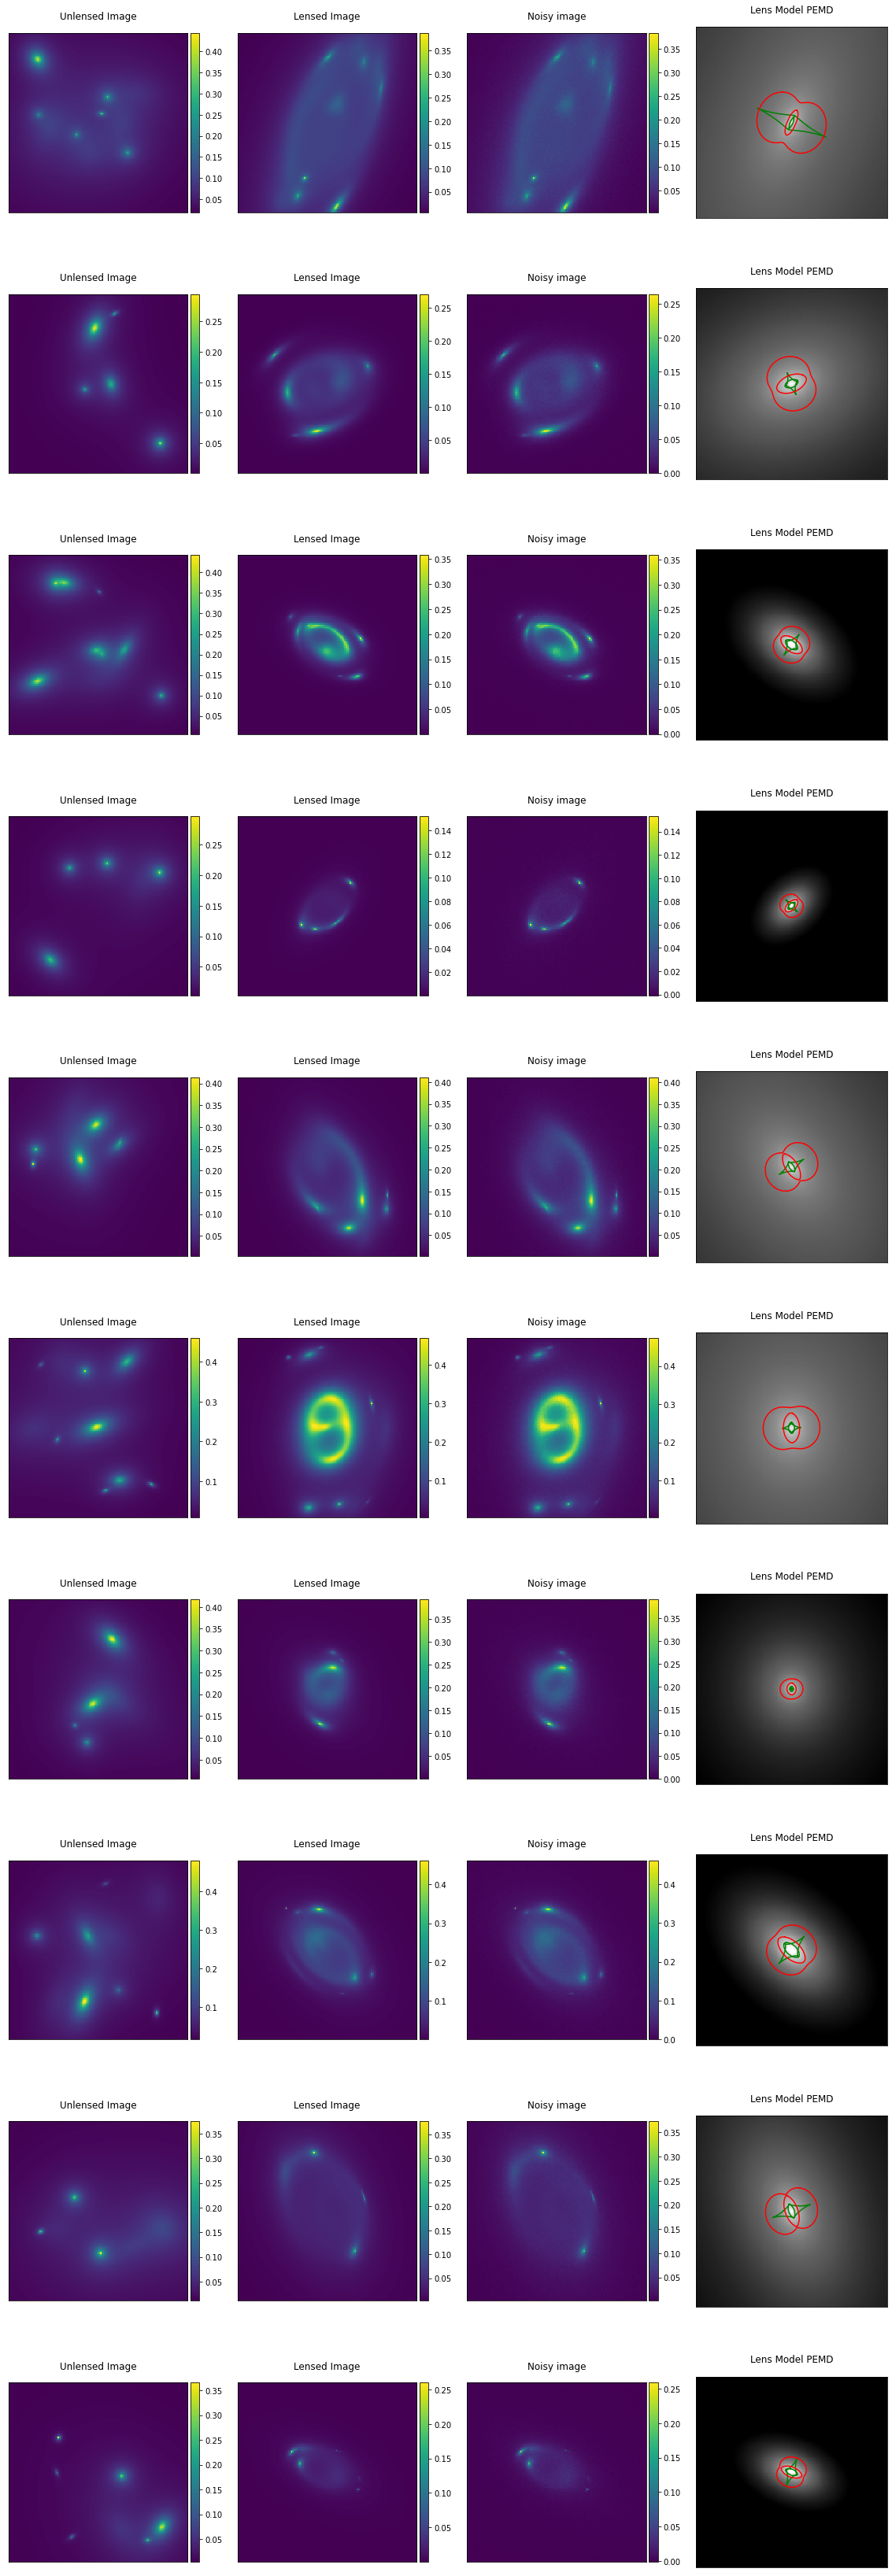

In [9]:
## Plot Dataset  
numPix=128 # numPix=number of pixels
deltaPix=0.05 # deltaPix=size of a pixel (in arcsec)

##n is the number of data
n=10000
## nb_affichage is the number of images plotted
nb_affichage=np.minimum(10,n)

L_affichage=np.linspace(0,n-1,num=nb_affichage,dtype='int')
print('indices of data plotted = '+str(L_affichage))


## Plot Images 
vizualize_dataset(L_affichage,unlensed_dataset,lensed_dataset,noisy_dataset,lens_parameters_dataset,source_parameters_dataset,n,nb_affichage,numPix,deltaPix)

## Shapelet Reconstructed dataset

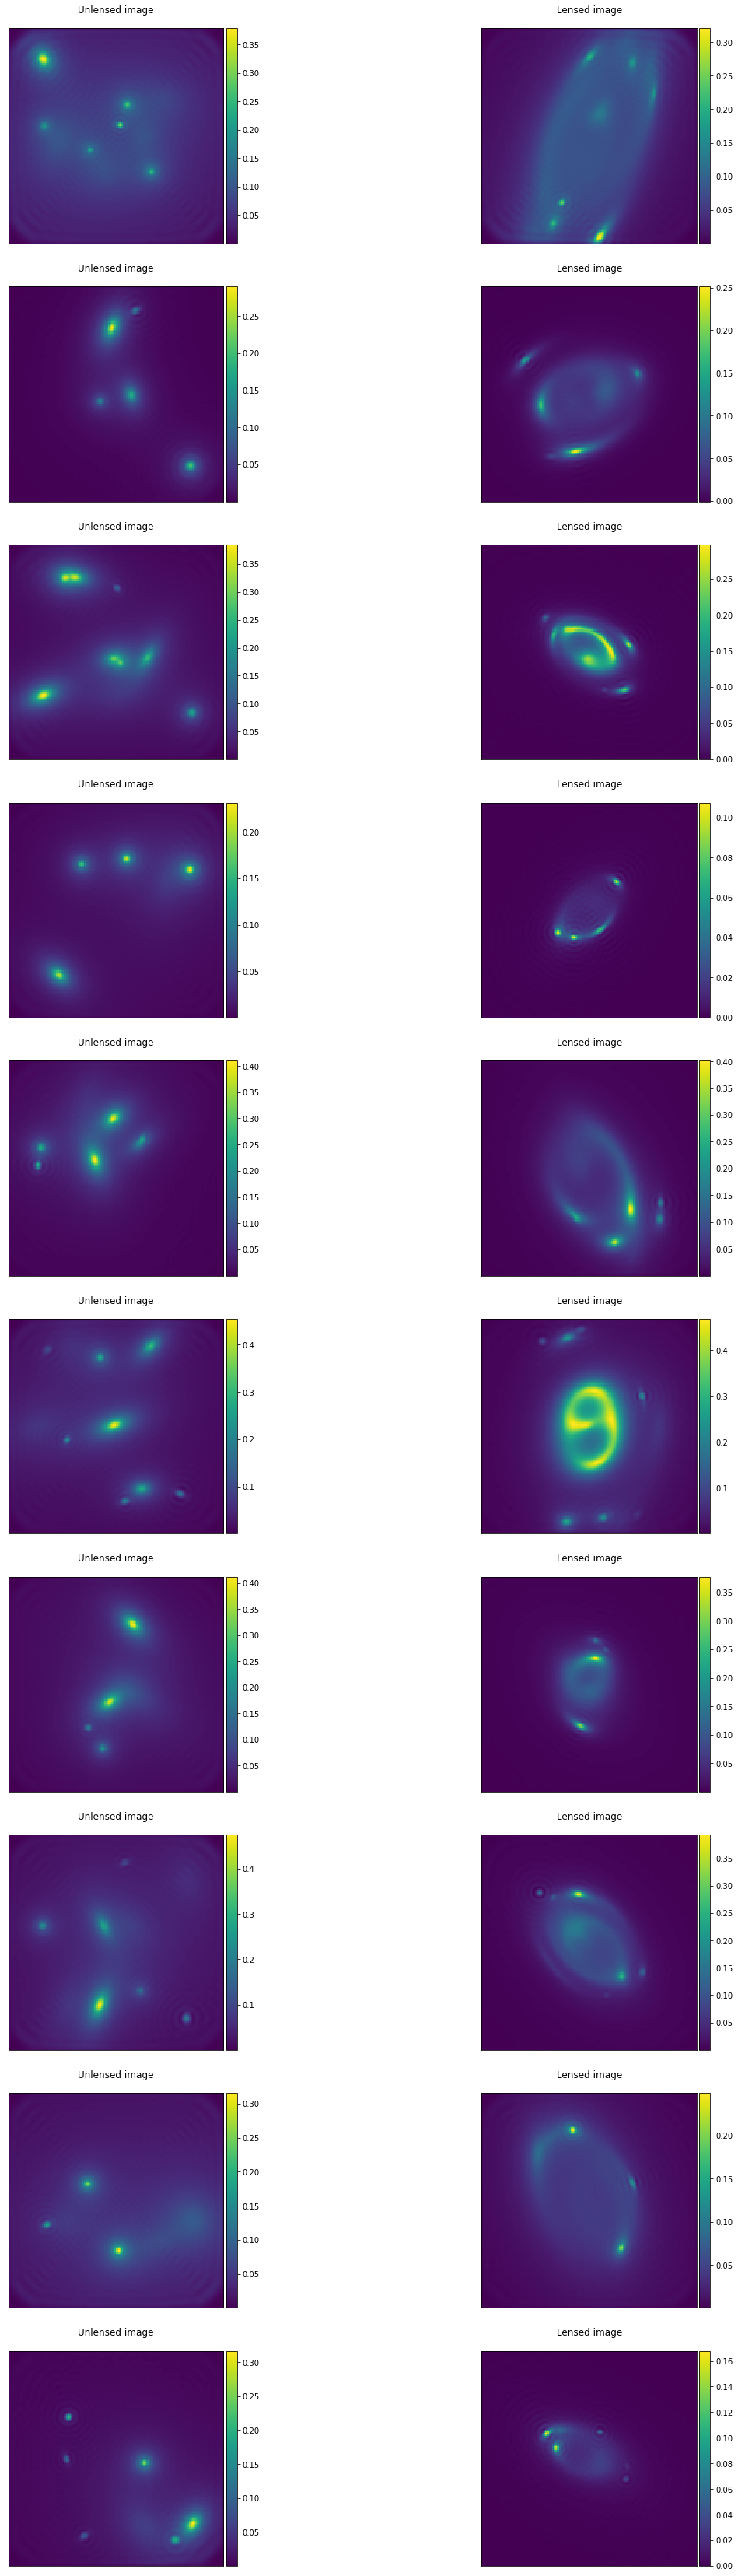

In [10]:
## Plot Reconstructed Images with Shapelets
vizualize_dataset_shapelet(L_affichage,unlensed_dataset_reconstructed_images,lensed_dataset_reconstructed_images,n,nb_affichage)

## Shapelet Coefficients Dataset

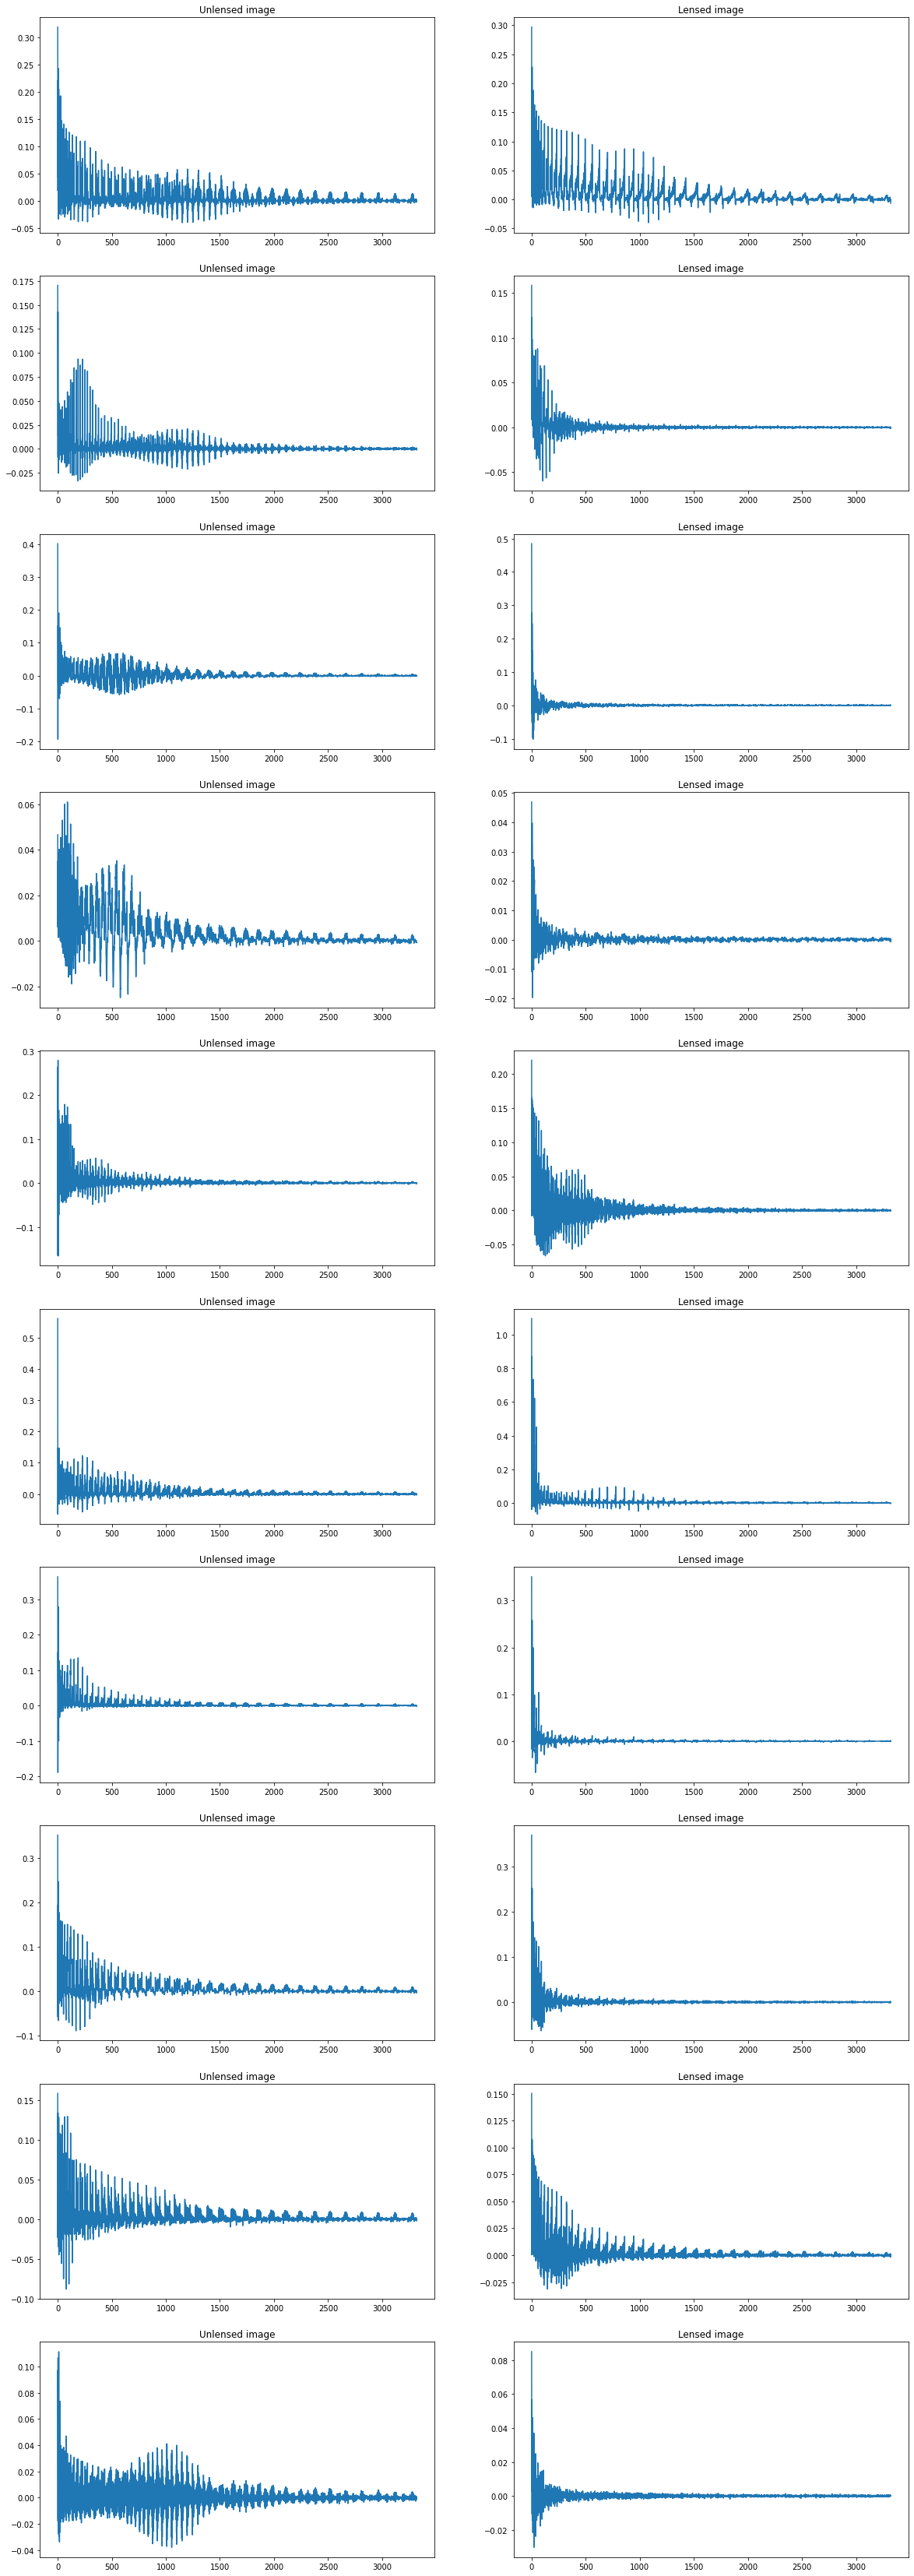

In [11]:
## Plot Distribution coeff shapelets
len_coeff_shapelet=len(unlensed_dataset_reconstructed_coeff[0])
vizualize_dataset_coeff_shapelet(len_coeff_shapelet,unlensed_dataset_reconstructed_coeff,lensed_dataset_reconstructed_coeff,L_affichage,n,nb_affichage)